# Setup

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=93ae7eb9261c664391c8da6d9ea1a3e84f7658b62d4273b656638ccc63702d1a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
# import statements
import torch
import torch.nn  as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
import random
from PIL import Image, ImageFont, ImageDraw
from torchsummary import summary
import os
from lime import lime_image
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Model

In [ ]:
class aMeijerNet(nn.Module):
  """Network architecture for the Meijer network.
     Check https://doi.org/10.1016/j.autcon.2019.04.013 for more."""

  def __init__(self):
    super(aMeijerNet, self).__init__()
    # input layer - 288x288x3
    # convolution layer - kernel 5x5 depth 32 ELU activation
    self.conv = nn.Conv2d(3, 32, kernel_size = 5, padding=2)
    self.elu = nn.ELU()
    # pooling layer - kernel 2x2 stride 2x2
    self.pool = nn.MaxPool2d(kernel_size = 2, padding=1)

    # convolution layer 2 - kernel 5x5 depth 32 ELU activation
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu2 = nn.ELU()
    # pooling layer 2 - kernel 2x2 stride 2x2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # convulation layer 3 - kernel 5x5 depth 32 ELU activation
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu3 = nn.ELU()
    # pooling layer 3 - kernel 2x2 stride 2x2
    self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

    # dense layer
    self.fc1 = nn.Linear(36, 512) # 32, 36, 36 -> 32, 36, 512
    # ELU activation
    self.elu4 = nn.ELU()
    # 50% dropout
    self.do1 = nn.Dropout2d(p=0.2)

    # dense layer 32, 36, 512
    self.fc2 = nn.Linear(512, 512)

    # ELU activation
    self.elu5 = nn.ELU()

    # 50% dropout
    self.do2 = nn.Dropout2d(p=0.2)

    # dense layer 32, 36, 512
    self.fc3 = nn.Linear(512, 512)

    # ELU activation
    self.elu6 = nn.ELU()

    # 50% dropout
    self.do3 = nn.Dropout2d(p=0.2)

    # output layer - 3 outputs (defect, cracks, LRCs) - sigmoid and round for each output, binary step function, etc.
    self.out = nn.Linear(294912, 3)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
   # x = torch.transpose(x, 1, 0)
    c = self.conv(x)
    e = self.elu(c)
    p = self.pool(e)

    c2 = self.conv2(p)
    e2 = self.elu2(c2)
    p2 = self.pool2(e2)

    c3 = self.conv3(p2)
    e3 = self.elu3(c3)
    p3 = self.pool3(e3)

    fc1 = self.fc1(p3)
    e4 = self.elu4(fc1)
    do1 = self.do1(e4)

    fc2 = self.fc2(do1)
    e5 = self.elu5(fc2)
    do2 = self.do2(e5)

    fc3 = self.fc3(do2)
    e6 = self.elu6(fc3)
    do3 = self.do3(e6)

    out = self.sigm(self.out(torch.flatten(do3, start_dim=1, end_dim=-1)))

    return out

In [ ]:
net = aMeijerNet() # instance of class

In [ ]:
net # network architecture

aMeijerNet(
  (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu): ELU(alpha=1.0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu2): ELU(alpha=1.0)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (elu3): ELU(alpha=1.0)
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36, out_features=512, bias=True)
  (elu4): ELU(alpha=1.0)
  (do1): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (elu5): ELU(alpha=1.0)
  (do2): Dropout2d(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (elu6): ELU(alpha=1.0)
  (do3): Dropout2d(p=0.2, inplace=False)
  (out): Linear(in_features=294912, out_featu

# Dataset & Train/Validation

In [4]:
class SewerDataset(Dataset):
    """Declaration of a dataset for our sewer defect detection pipeline."""
    def __init__(self, datalocations, desiredW=288, desiredH=288):
        # rescale images to 288x288 (compression is better than expansion)
        self.datalocations = datalocations
        self.channels, self.desiredW, self.desiredH = 3, desiredW, desiredH

    def getArray(self, file, plot=False):
        """ This function is a helper for the dataset getter method (__getitem__).
        It takes in the file location and a boolean to display plot.
        It returns an array scaled and transposed to Channel x Height x Width.
        """
        im = Image.open(f"{file}")
        if plot:
            im
        w, h = im.size
        rw, rh = (self.desiredW/w, self.desiredH/h)
        imRsz = im.resize((int(im.width * rw), int(im.height * rh)), resample=1)
        imArr = np.array(imRsz, dtype=np.float32).transpose((2, 0, 1)) # transpose inputs Cin, Hin, Win
        return imArr

    def __getitem__(self, index):
        """ This function gets the appropriate x and y values for all indices over the batch_size.
          It takes in 1+ indices.
          It returns the x and y values over the batch_size.
        """
        self.arr = np.zeros((self.channels, self.desiredW, self.desiredH))
        if index == 0:
            self.arr = self.getArray(self.datalocations[index], True)
        else:
            self.arr = self.getArray(self.datalocations[index])
        label = np.array([int(self.datalocations[index][-7]),
                 int(self.datalocations[index][-6]),
                 int(self.datalocations[index][-5])])
        return self.arr, label

    def __len__(self):
        return len(self.datalocations)

datalocation = "/content/drive/MyDrive/ENGG-680-ProjectDataDestination/" # replace with location of "ENGG-680-ProjectDataDestination" on your machine
pre = "/content/drive/MyDrive/ENGG-680-Project/"
files = list(set(os.listdir(datalocation)) - {'desktop.ini', 'whatever.ini'}) # list files in image directory
files = [datalocation+file for file in files]
saveFiles = f"{pre}model/saved/"

# apply 75% training, 15% for test, 10% validation
_, _, filesTrain, filesTest = train_test_split(files, files, test_size=0.25, random_state=55)
_, _, filesTest, filesVal = train_test_split(filesTest, filesTest, test_size=10/25, random_state=55)

trainSet = SewerDataset(filesTrain) # declare the train dataset
valSet = SewerDataset(filesVal) # declare the validation dataset
criterion = nn.BCELoss() # initialize binary cross entropy loss
trainLoader = DataLoader(dataset=trainSet, batch_size=64)
valLoader = DataLoader(dataset=valSet, batch_size=64)

# build networks and validate over all 5 learning rates (hyperparameter training)
learningRates = [.01, .05, .001, .005] + [.0001, .0005]
learningRates.sort()
print(learningRates)
trainErr = torch.zeros(len(learningRates))
valErr = torch.zeros(len(learningRates))
Models = {}
epochs = 1
learningRateLosses = []
# ---- UNCOMMENT EVERYTHING BELOW IF INTENT IS TO RERUN VALIDATION STAGES
# for i, lr in enumerate(learningRates):
#     net = aMeijerNet()
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#     for epoch in range(epochs):
#         for x, y in trainLoader:
#             yHat = net(x)
#             loss = criterion(yHat, y.to(torch.float32))
#             print(f"Learning rate: {lr}; epoch: {epoch}; loss: {loss}.")
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         torch.save(net, f"{saveFiles}net_{str(lr).replace('.', '_')}_{epoch}.pth")
#     for x, y in trainLoader:
#         # training data
#         yhat = net(x)
#         trainLoss = criterion (yhat, y.to(torch.float32))
#         trainErr[i] = trainLoss.item()
#     net = torch.load(f"{saveFiles}net_{str(lr).replace('.', '_')}_{epochs-1}.pth")
#     print(f"{str(lr).replace('.', '_')} network loaded.")
#     losses=[]
#     with torch.no_grad():
#       for idx, (x, y) in enumerate(valLoader):
#           print(x.shape)
#           # validation data
#           yhat = net(x)
#           valLoss = criterion(yhat, y.to(torch.float32))
#           valErr[i] = valLoss.item()
#           losses.append(valLoss)
#           print(f"Loss {idx+1}: {valLoss}")
#       learningRateLosses.append(losses)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/'

In [ ]:
# get the learning rate results
lrLossesArray = np.array(learningRateLosses)
lrLossesMean = np.mean(lrLossesArray, axis=1)
print(lrLossesArray.shape, lrLossesMean.shape)

# Hyperparameter Selection (Learning Rate)

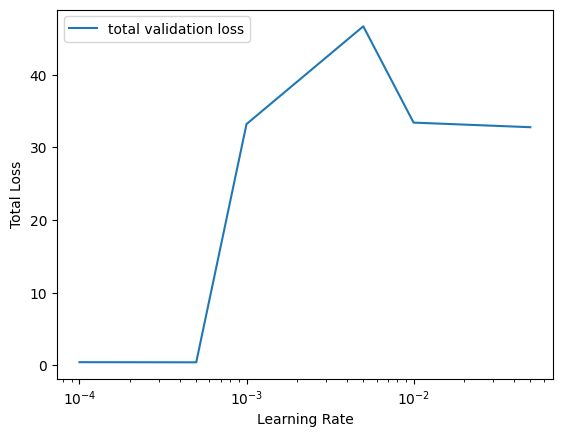

In [9]:
#plt.semilogx(np.array(learning_rates), trainErr.numpy(), label="total training loss")
saveFigsFiles = f"{pre}figures/"
learningRates = np.load(f"{saveFigsFiles}learningRates.npy")
lrLossesMean = np.load(f"{saveFigsFiles}lrLossesMean.npy")
# -- UNCOMMENT IF INTENT IS TO RUN AGAIN
# with open(f"{saveFigsFiles}learningRates.npy", "wb") as f:
#     np.save(f, np.array(learningRates))

# with open(f"{saveFigsFiles}lrLossesMean.npy", "wb") as f:
#     np.save(f, lrLossesMean)
# -- END UNCOMMENT

plt.semilogx(learningRates, lrLossesMean, label="total validation loss")
plt.ylabel("Total Loss")
plt.xlabel("Learning Rate")
plt.legend()
plt.savefig(f"{saveFigsFiles}validation-semilog.png")
plt.show()

# Complete Training

In [ ]:
# complete training with the best epoch = 0.0005 (selected hyper parameter)
learningRate = 0.0005
epochs=1
net = torch.load(f"{saveFiles}net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth", map_location ="cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
maxEpochs = 100
for epoch in range(epochs, maxEpochs):
    for x, y in trainLoader:
        # x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        yHat = net(x)
        loss = criterion(yHat, y.to(torch.float32))
        print(f"Learning rate: {learningRate}; epoch: {epoch}; loss: {loss}.")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch>=80: torch.save(net, f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epoch}.pth")


<ipython-input-13-e9e261c3018f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth")#, m

Streaming output truncated to the last 5000 lines.
Learning rate: 0.0005; epoch: 51; loss: 0.32666125893592834.
Learning rate: 0.0005; epoch: 51; loss: 0.11836590617895126.
Learning rate: 0.0005; epoch: 51; loss: 0.11290961503982544.
Learning rate: 0.0005; epoch: 51; loss: 0.15674147009849548.
Learning rate: 0.0005; epoch: 51; loss: 0.20513038337230682.
Learning rate: 0.0005; epoch: 51; loss: 0.12848779559135437.
Learning rate: 0.0005; epoch: 51; loss: 0.021583549678325653.
Learning rate: 0.0005; epoch: 51; loss: 0.15656794607639313.
Learning rate: 0.0005; epoch: 52; loss: 0.06900446861982346.
Learning rate: 0.0005; epoch: 52; loss: 0.09069492667913437.
Learning rate: 0.0005; epoch: 52; loss: 0.20104965567588806.
Learning rate: 0.0005; epoch: 52; loss: 0.05817723274230957.
Learning rate: 0.0005; epoch: 52; loss: 0.24487046897411346.
Learning rate: 0.0005; epoch: 52; loss: 0.2172020971775055.
Learning rate: 0.0005; epoch: 52; loss: 0.03779556602239609.
Learning rate: 0.0005; epoch: 52; 

# Hyperparameter Selection (Epoch)

In [3]:
# select best epoch from 80 to 100 epochs
valErrEpoch = [] # initialize empty array
epochFileNames = [] # initialize empty array

for epochFile in os.listdir(f"{saveFiles}finalForty/"): # for every epoch file
  netEval = torch.load(f"{saveFiles}finalForty/{epochFile}", map_location ="cpu")
  #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #net.to("cuda:0")
  valLosses = []
  for i, (x, y) in enumerate(valLoader):
      #x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
      yhat = netEval(x)
      valLoss = criterion(yhat, y.to(torch.float32))
      valLosses.append(valLoss.item())
  valErrEpoch.append(valLosses)
  epochFileNames.append(epochFile)
valErrEpoch = np.array(valErrEpoch) # create validation error arrays for each epoch

NameError: name 'saveFiles' is not defined

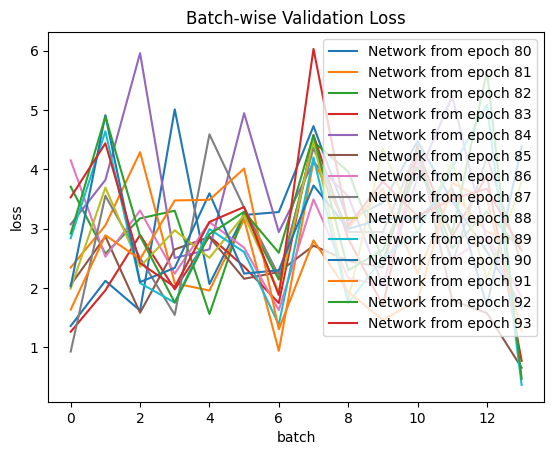

In [15]:
# -- UNCOMMENT IF INTENT IS NOT TO RUN AGAIN
# with open(f"{saveFigsFiles}epochSelectionValidation.npy", "wb") as f:
#     np.save(f, valErrEpoch)

# -- END UNCOMMENT
valErrEpoch=np.load(f"{saveFigsFiles}epochSelectionValidation.npy")
nfiles = valErrEpoch.shape[0]
nbatches = valErrEpoch.shape[1]

for i in range(nbatches):
  plt.plot(list(range(nbatches)), valErrEpoch[i,:])

# plot batch losses for each epoch
plt.xlabel("batch")
plt.ylabel("loss")
plt.legend([f"Network from epoch {i}" for i in list(range(80, 100))])
plt.title("Batch-wise Validation Loss")
plt.savefig(f"{saveFigsFiles}epochSelectionValidation.png") # UNCOMMENT IF INTENT IS TO RUN AGAIN
plt.show()

#minIndex = np.argmin(np.mean(valErrEpoch, axis=1))
#bestFile = epochFileNames[minIndex]
#print(f"The best epoch index is {minIndex} and network is {bestFile}.")

# Testing

In [ ]:
testSet = SewerDataset(filesTest) # create test set dataset
learningRate = .0005
nTest = len(filesTest)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bestFile="net_0_0005_85.pth"

net = torch.load(f"{saveFiles}finalForty/{bestFile}", map_location="cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#net.to("cuda:0")

#initialize zero arrays
predictionsCrack = np.zeros(nTest, )
predictionsLrc = np.zeros(nTest, )
predictionsDefect = np.zeros(nTest, )
actualCrack, actualLrc, actualDefect = np.zeros(nTest, ), np.zeros(nTest, ), np.zeros(nTest, )

testLoader = DataLoader(dataset=testSet, batch_size=1) # declare the data loader
for i, (x, y) in enumerate(testLoader):
  #x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32) #?
  predictions = net(x) # make prediction
  predictions = torch.round(predictions, decimals=0) # rounding probability outputs
  predictions = predictions#.to("cpu").detach().numpy()
  predictions = predictions.reshape(-1,) # reshape predictions
  predictionsCrack[i] = predictions[0]
  predictionsLrc[i] = predictions[1]
  predictionsDefect[i] = predictions[2]
  actualCrack[i] = y[0][0] #.to("cpu").detach().numpy().reshape(-1,)
  actualLrc[i] = y[0][1] #.to("cpu").detach().numpy().reshape(-1,)
  actualDefect[i] = y[0][2] #.to("cpu").detach().numpy().reshape(-1,)

<ipython-input-45-c775a72f7894>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}finalForty/{bestFile}", map_location="cpu")


In [ ]:
# print classification reports and confusion matrices
print(f"For cracks: {classification_report(actualCrack, predictionsCrack)}\n{confusion_matrix(actualCrack, predictionsCrack)}.\n")
print(f"For LRC: {classification_report(actualLrc, predictionsLrc)}\n{confusion_matrix(actualLrc, predictionsLrc)}.\n")
print(f"For defect: {classification_report(actualDefect, predictionsDefect)}\n{confusion_matrix(actualDefect, predictionsDefect)}.")

For cracks:               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      1019
         1.0       0.89      0.88      0.89       308

    accuracy                           0.95      1327
   macro avg       0.93      0.92      0.93      1327
weighted avg       0.95      0.95      0.95      1327

[[986  33]
 [ 37 271]].

For LRC:               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       980
         1.0       0.94      0.92      0.93       347

    accuracy                           0.96      1327
   macro avg       0.95      0.95      0.95      1327
weighted avg       0.96      0.96      0.96      1327

[[959  21]
 [ 29 318]].

For defect:               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       675
         1.0       0.96      0.92      0.94       652

    accuracy                           0.94      1327
   macro avg       0.94      0.94      0.94  

In [ ]:
def printCM(data, title):
  '''Function to print confusion matrix.'''
  plt.axis('off')
  plt.imshow(data, cmap='summer', interpolation='nearest')

  plt.colorbar()

  for i in range(data.shape[0]):  # Loop through rows
     for j in range(data.shape[1]):  # Loop through columns
         plt.annotate(str(data[i][j]), xy=(j, i),
                     ha='center', va='center', color='black')


  plt.title(f'{title}')
  plt.xlabel('Predicted Values')
  plt.ylabel('Actual Values')
  plt.show()


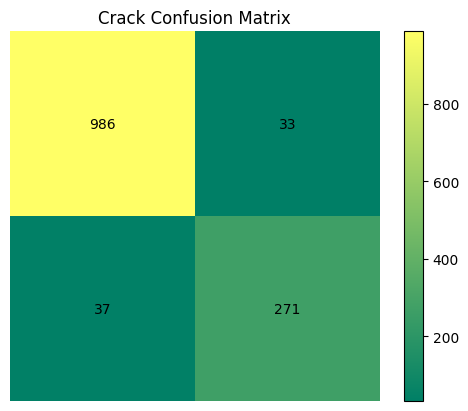

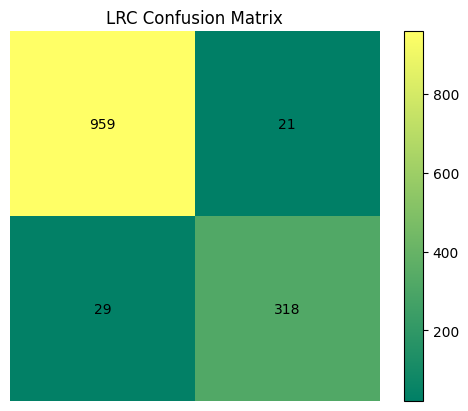

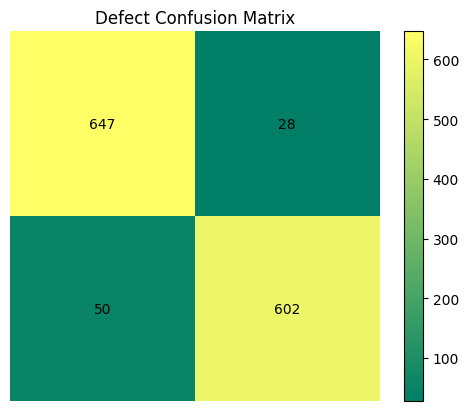

In [ ]:
data = np.array([[986,  33],
 [ 37, 271]])
printCM(data, "Crack Confusion Matrix")

data = np.array([[959,  21],
 [ 29, 318]])
printCM(data, "LRC Confusion Matrix")

data = np.array([[647,  28],
 [ 50, 602]])
printCM(data, "Defect Confusion Matrix")

In [ ]:
# save data for future reference
with open(f"{saveFigsFiles}actualCrack.npy", "wb") as f:
    np.save(f, actualCrack)
with open(f"{saveFigsFiles}predictionsCrack.npy", "wb") as f:
    np.save(f, predictionsCrack)
with open(f"{saveFigsFiles}actualLrc.npy", "wb") as f:
    np.save(f, actualLrc)
with open(f"{saveFigsFiles}predictionsLrc.npy", "wb") as f:
    np.save(f, predictionsLrc)
with open(f"{saveFigsFiles}actualDefect.npy", "wb") as f:
    np.save(f, actualDefect)
with open(f"{saveFigsFiles}predictionsDefect.npy", "wb") as f:
    np.save(f, predictionsDefect)

# load saved data
actualCrack=np.load(f"{saveFigsFiles}actualCrack.npy")
predictionsCrack=np.load(f"{saveFigsFiles}predictionsCrack.npy")
actualLrc=np.load(f"{saveFigsFiles}actualLrc.npy")
predictionsLrc=np.load(f"{saveFigsFiles}predictionsLrc.npy")
actualDefect=np.load(f"{saveFigsFiles}actualDefect.npy")
predictionsDefect=np.load(f"{saveFigsFiles}predictionsDefect.npy")

In [ ]:
def PRAUC(ytrue, ypred, saveFigsFiles, saveFigName):
  """This function plots the PR-AUC curve which is most appropriate for imbalanced datasets like ours.
    It takes in the actual y and the predicted y as well as two other parameters for location of file and file name with .png.
    It returns None."""

  # calculate roc curve for model
  precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
  # plot model roc curve
  plt.plot(precision, recall, marker=".", label="pr-auc curve")
  plt.plot(thresholds, "--", color="orange", label="best")
  # axis labels
  plt.xlabel("precision")
  plt.ylabel("recall")
  # show the legend
  plt.legend()
  # show the plot
  plt.savefig(f"{saveFigsFiles}{saveFigName}")
  plt.show()

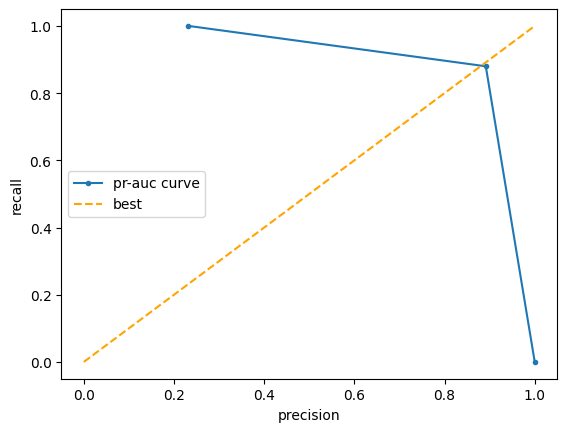

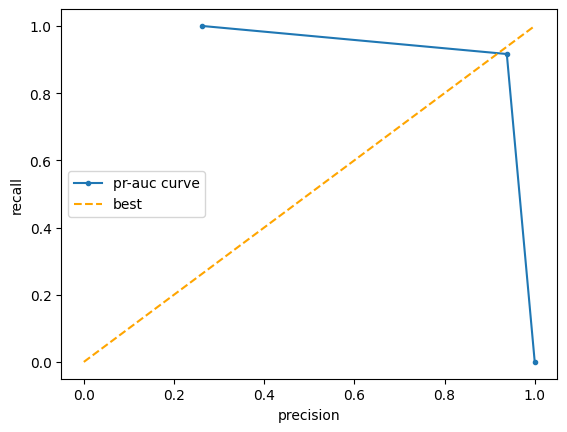

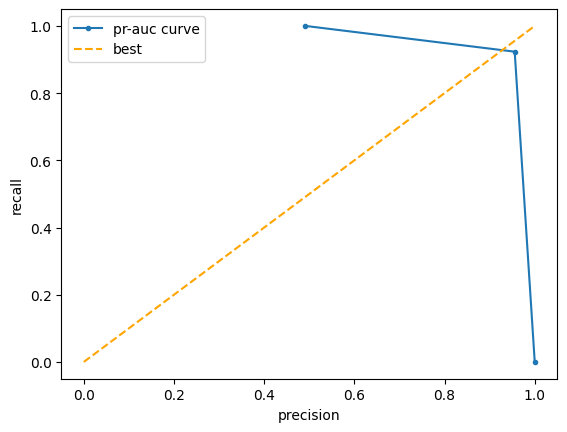

In [ ]:
# plot pr-auc and thresholds in yellow ("optimal balance")
PRAUC(actualCrack, predictionsCrack, saveFigsFiles, "prauc_crack.png")
PRAUC(actualLrc, predictionsLrc, saveFigsFiles, "prauc_lrc.png")
PRAUC(actualDefect, predictionsDefect, saveFigsFiles, "prauc_defect.png")

# Data Analysis


In [ ]:
# number of training, testing, and validation files for data overview
len(filesTrain), len(filesTest), len(filesVal)

(6635, 1327, 885)

In [ ]:
fset = set(files) # create a set of files
pre = "/content/drive/MyDrive/ENGG-680-Project/data/"
filenames = pd.read_excel(f"{pre}Combined excel.xlsx", usecols="A,B,C,D,R,U,V") # extract relevant columns from data
filenames = filenames.set_index("Filename") # assign Filename to index

# # a renaming procedure
# for file in fset:
#     attrib = file.split("_")
#     name = attrib[0]+".png"
#     OSvalue = filenames.loc[name, "OS"]
#     newattrib = attrib[0] +"_"+ attrib[1] +"_"+ attrib[2][0] + str(OSvalue) + attrib[2][2:]
#     os.rename(f"{datalocation}{file}", f"{datalocation}{newattrib}")

#print("Done rename.")

In [ ]:
# obtain labels
fileLabels = {}
for file in files:
    attrib = file.split("_")
    fileLabels[file] = {"va":attrib[1], "defectLabel":attrib[2][2], "crackLabel":attrib[2][0],  "lrcLabel":attrib[2][1]}
fileLabels

{'/content/drive/MyDrive/ENGG-680-ProjectDataDestination/00491538_1_101.png': {'va': '1',
  'defectLabel': '1',
  'crackLabel': '1',
  'lrcLabel': '0'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/00487644_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/00001735_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/01117907_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/01127981_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/00748150_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '/content/drive/MyDrive/ENGG-680-ProjectDataDestination/00339667_0_101.png': {'va

In [ ]:
df = pd.DataFrame.from_dict(fileLabels, orient='index')
df.head()
df["defectLabel"] = df.defectLabel.astype(np.uint16)
df["crackLabel"] = df.crackLabel.astype(np.uint16)
df["lrcLabel"] = df.lrcLabel.astype(np.uint16)
df["va"] = df.lrcLabel.astype(np.float32)

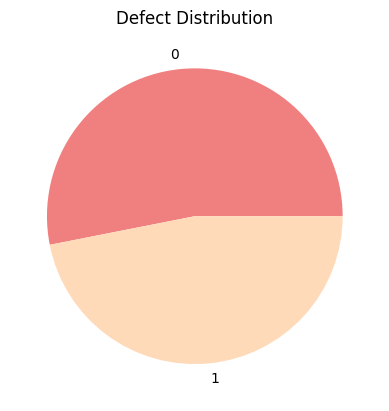

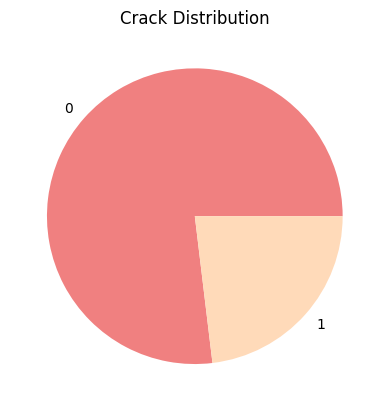

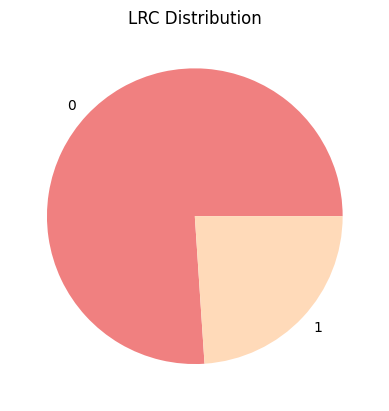

In [ ]:
# create pie diagrams of each label (defects, crakcs, and LRCs)
describeDefects = df.defectLabel.value_counts()
describeDefects
plt.pie(describeDefects, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Defect Distribution")
plt.savefig(saveFigsFiles+"defectDistribution.png")
plt.show()

describeCracks = df.crackLabel.value_counts()
describeCracks
plt.pie(describeCracks, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Crack Distribution")
plt.savefig(saveFigsFiles+"crackDistribution.png")
plt.show()

describeLatcut = df.lrcLabel.value_counts()
describeLatcut
plt.pie(describeLatcut, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("LRC Distribution")
plt.savefig(saveFigsFiles+"lrcDistribution.png")
plt.show()

# Explainability

In [ ]:
xGUICAM, yGUICAM = [], [] # initialize two empty arrays to store first 30 examples
count = 0
for i, (x, y) in enumerate(testLoader):
  print(f"Current count at {count}.")
  if y[0][2] != 0 and count != 15:
    xGUICAM.append(x)
    yGUICAM.append(y)
    count += 1
  elif y[0][2] == 0 and count < 30:
    xGUICAM.append(x)
    yGUICAM.append(y)
    count += 1
  elif count >= 30:
    print("Got the 30 examples.")
    break
  else:
    continue

Current count at 0.
Current count at 1.
Current count at 2.
Current count at 3.
Current count at 4.
Current count at 5.
Current count at 6.
Current count at 7.
Current count at 8.
Current count at 9.
Current count at 10.
Current count at 11.
Current count at 12.
Current count at 13.
Current count at 14.
Current count at 15.
Current count at 16.
Current count at 17.
Current count at 18.
Current count at 19.
Current count at 20.
Current count at 21.
Current count at 22.
Current count at 23.
Current count at 24.
Current count at 25.
Current count at 26.
Current count at 27.
Current count at 28.
Current count at 29.
Current count at 30.
Got the 30 examples.


In [ ]:
len(xGUICAM), len(yGUICAM)

(30, 30)

In [ ]:
def predictProbs(images):
  """
  This function gets the images' predictions.
  It takes in a number of images (for this purpose transformed).
  It returns the output of our network.
  """
  print(images.shape)
  IMAGES = images.transpose(0, 3, 2, 1)
  return net(torch.from_numpy(IMAGES)).detach()

# GUI

In [ ]:
# https://coordinates-converter.com/en/decimal/51.025327,-114.049868?karte=OpenStreetMap&zoom=8
# 51.113268, -114.225369 NORTH WEST
# 50.900844, -113.912041 SOUTH EAST
def getCoords(cityBoundariesDDLat=(50.900844, 51.113268), cityBoundariesDDLon=(-113.912041, -114.225369), buffer=.02):
  """This function generates coordinates according to its constraints (default is Calgary).
    It takes in a tuple of latitude coordinates and tuple of longitude coordinates in decimal degrees and tolerance.
    It returns the randomly selected latitude and longitude coordinates."""
  return random.uniform(cityBoundariesDDLat[0]+buffer, cityBoundariesDDLat[1]-buffer), random.uniform(cityBoundariesDDLon[0]-buffer, cityBoundariesDDLon[1]+buffer)

def locate(latlon, windowSize, cityBoundariesDDLat=(50.900844, 51.113268), cityBoundariesDDLon=(-113.912041, -114.225369)):
  """This function translates from map coordinates to GUI coordinates (in pixels).
    It takes a latitude and longitude, a window size, and latitude and longitude boundaries.
    It returns the appropriate pixel x and y coordinates."""
  lat, lon = latlon
  x = (lat - cityBoundariesDDLat[0])*(windowSize[0] - 0)/(cityBoundariesDDLat[1] - cityBoundariesDDLat[0])
  y = (lon - cityBoundariesDDLon[0])*(windowSize[1] - 0)/(cityBoundariesDDLon[1] - cityBoundariesDDLon[0])
  return x, y

In [ ]:
windowSize=(500*10+300, 500*10+300) # declaration of window size tuple in width, height, and channels
window = Image.open(f"{saveFigsFiles}map_of_calgary.PNG").convert("RGB") # initialize ones matrix
window = window.resize(windowSize)
window = np.array(window)
print(window.shape)
# color variation for windows for normal images and explanations for decision for cracks, LRCs, and defects, respectively
windowc = np.array(window)
windowl = np.array(window)
windowd = np.array(window)

# initialize explanation tool
explainer = lime_image.LimeImageExplainer()
# load network
net = torch.load(f"{saveFiles}finalForty/{bestFile}", map_location ="cpu")

for x, y in zip(xGUICAM, yGUICAM):
  print(x.shape)
  arrX = torch.transpose(x.squeeze(0), 0,2).to("cpu").detach().numpy()
  explanationCracks = explainer.explain_instance(arrX,
                                            predictProbs,
                                            labels=(0, ),
                                            hide_color=None,
                                            top_labels=1,
                                            num_features=100000,
                                            num_samples=1000,
                                            batch_size=100,
                                            segmentation_fn=None,
                                            distance_metric='cosine',
                                            model_regressor=None,
                                            random_seed=None)
  # get the explanation for the top label
  tempCracks, maskCracks = explanationCracks.get_image_and_mask(explanationCracks.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  explanationLrcs = explainer.explain_instance(arrX,
                                          predictProbs,
                                          labels=(1, ),
                                          hide_color=None,
                                          top_labels=1,
                                          num_features=100000,
                                          num_samples=1000,
                                          batch_size=100,
                                          segmentation_fn=None,
                                          distance_metric='cosine',
                                          model_regressor=None,
                                          random_seed=None)
  # get the explanation for the top label
  tempLrcs, maskLrcs = explanationLrcs.get_image_and_mask(explanationLrcs.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

  explanationDefects = explainer.explain_instance(arrX,
                                        predictProbs,
                                        labels=(2, ),
                                        hide_color=None,
                                        top_labels=1,
                                        num_features=100000,
                                        num_samples=1000,
                                        batch_size=100,
                                        segmentation_fn=None,
                                        distance_metric='cosine',
                                        model_regressor=None,
                                        random_seed=None)
  # get the explanation for the top label
  tempDefects, maskDefects = explanationDefects.get_image_and_mask(explanationDefects.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

  # get mask and assign all 0s a value of .1
  maskCracks[maskCracks==0], maskLrcs[maskLrcs==0], maskDefects[maskDefects==0] = .1, .1, .1

  # create arrays as a function of the images and the masks
  arrX = x
  arrX2 = (tempCracks * np.concatenate([np.expand_dims(maskCracks, -1)]*3, axis=2))
  arrX3 = (tempLrcs * np.concatenate([np.expand_dims(maskLrcs, -1)]*3, axis=2))
  arrX4 = (tempDefects * np.concatenate([np.expand_dims(maskDefects, -1)]*3, axis=2))
  arr = arrX.numpy().squeeze(0).transpose(1,2,0)
  arr2 = arrX2#.to("cpu").detach().numpy().squeeze(0).transpose(1,2,0) #+ arrHm
  arr3 = arrX3#.to("cpu").detach().numpy().squeeze(0).transpose(1,2,0) #+ arrHm
  arr4 = arrX4#.to("cpu").detach().numpy().squeeze(0).transpose(1,2,0) #+ arrHm

  # create pillow images
  image = Image.fromarray((arr * 255).astype(np.uint8))
  image2 = Image.fromarray((arr2 * 255).astype(np.uint8))
  image3 = Image.fromarray((arr3 * 255).astype(np.uint8))
  image4 = Image.fromarray((arr4 * 255).astype(np.uint8))

  # add labels to corner of image ###
  drawLabels = ImageDraw.Draw(image)
  drawLabelsCrack = ImageDraw.Draw(image2)
  drawLabelsLrcs = ImageDraw.Draw(image3)
  drawLabelsDefects = ImageDraw.Draw(image4)
  font = ImageFont.load_default(60)
  drawLabels.text((180, 180), str(y[0][0].detach().numpy()) + str(y[0][1].detach().numpy()) + str(y[0][2].detach().numpy()), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255),  font=font)
  drawLabelsCrack.text((180, 180), str(y[0][0].detach().numpy()), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255), font=font)
  drawLabelsLrcs.text((180, 180), str(y[0][1].detach().numpy()), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255),  font=font)
  drawLabelsDefects.text((180, 180), str(y[0][2].detach().numpy()), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255),  font=font)

  # use coordinates command
  coords = getCoords()
  xPlace, yPlace = locate(coords, windowSize) # get locations of images on GUI
  xPlace, yPlace = int(xPlace), int(yPlace)

  # add labels to corner of image ###
  drawCoords = ImageDraw.Draw(image)
  drawCoordsCracks = ImageDraw.Draw(image2)
  drawCoordsLrcs = ImageDraw.Draw(image3)
  drawCoordsDefects = ImageDraw.Draw(image4)
  font = ImageFont.load_default(30)
  stringCoords = [str(round(c, 3)) for c in coords]
  drawCoords.text((10, 10), ",".join(stringCoords), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255), font=font)
  drawCoordsCracks.text((10, 10), ",".join(stringCoords), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255),  font=font)
  drawCoordsLrcs.text((10, 10), ",".join(stringCoords), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255),  font=font)
  drawCoordsDefects.text((10, 10), ",".join(stringCoords), font_color=(255,255,255), fill=(255,255,255), stroke_fill=(255,255,255), font=font)

  # place images on GUI
  window[xPlace:xPlace+288, yPlace:yPlace+288, :] =  np.array(image)
  windowc[xPlace:xPlace+288, yPlace:yPlace+288, :] = np.array(image2)
  windowl[xPlace:xPlace+288, yPlace:yPlace+288, :] = np.array(image3)
  windowd[xPlace:xPlace+288, yPlace:yPlace+288, :] = np.array(image4)

(5300, 5300, 3)


<ipython-input-36-3455ee7dcc5e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}finalForty/{bestFile}", map_location ="cpu")


torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
torch.Size([1, 3, 288, 288])


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)
(100, 288, 288, 3)


In [ ]:
# RUN NORMAL IMAGE GUI
GUI = Image.fromarray((window * 255).astype(np.uint8))
GUI = GUI.resize((2000, 2000))
draw = ImageDraw.Draw(GUI)
font = ImageFont.load_default(120)
draw.text((10, 10),"GUI - Map of Calgary Pipes", (0,0,0), font=font)
GUI.save(f"{saveFigsFiles}GUI.png")
GUI

In [ ]:
# RUN CRACKS IMAGE GUI
GUICracks = Image.fromarray((windowc * 255).astype(np.uint8))
GUICracks = GUICracks.resize((2000, 2000))
draw = ImageDraw.Draw(GUICracks)
font = ImageFont.load_default(120)
draw.text((10, 10),"GUI of Cracks in Calgary Pipes",(0,0,0), font=font)
GUICracks.save(f"{saveFigsFiles}GUICracks.png")
GUICracks

In [ ]:
# RUN LRCs IMAGE GUI
GUILrcs = Image.fromarray((windowl * 255).astype(np.uint8))
GUILrcs = GUILrcs.resize((2000, 2000))
draw = ImageDraw.Draw(GUILrcs)
font = ImageFont.load_default(120)
draw.text((10, 10),"GUI of LRCs in Calgary Pipes",(0,0,0), font=font)
GUILrcs.save(f"{saveFigsFiles}GUILrcs.png")
GUILrcs

In [ ]:
# FINALLY... RUN DEFECTS IMAGE GUI
GUIDefects = Image.fromarray((windowd * 255).astype(np.uint8))
GUIDefects = GUIDefects.resize((2000, 2000))
draw = ImageDraw.Draw(GUIDefects)
font = ImageFont.load_default(120)
draw.text((10, 10),"GUI of Defects in Calgary Pipes",(0,0,0), font=font)
GUIDefects.save(f"{saveFigsFiles}GUIDefects.png")
GUIDefects